🔧 Starting BATCH LABELING on all patches...
📁 Found 384 total patches
📍 Found 16 unique locations

📊 LABEL DISTRIBUTION:
MINING patches: 384
NON-MINING patches: 0
Total patches: 384
Mining ratio: 100.0%


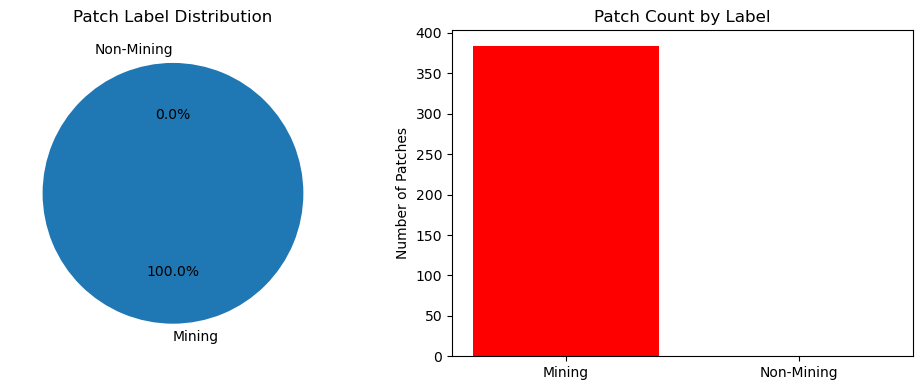

💾 Comprehensive labels saved to: ../data/annotations/comprehensive_labels.json


TypeError: Object of type float32 is not JSON serializable

In [1]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

# Setup paths
PATCHES_DIR = "../data/processed/patches_all"
os.makedirs("../data/annotations", exist_ok=True)

def load_all_patches(patches_dir):
    """Load all patches from all subdirectories"""
    all_patches = []
    
    for root, dirs, files in os.walk(patches_dir):
        for file in files:
            if file.endswith('.npy') and 'patch_' in file:
                full_path = os.path.join(root, file)
                all_patches.append(full_path)
    
    print(f"📁 Found {len(all_patches)} total patches")
    return all_patches

def temporal_change_detection(all_patches):
    """Enhanced temporal change detection using all time points"""
    # Group patches by location across all images
    location_groups = defaultdict(list)
    
    for patch_path in all_patches:
        # Extract location from path: .../S2_Yamuna_2023_01/patch_0_256.npy
        path_parts = Path(patch_path).parts
        image_name = path_parts[-2]  # Directory name
        patch_file = path_parts[-1]  # File name
        
        # Extract coordinates from patch filename
        coords = patch_file.replace('patch_', '').replace('.npy', '').split('_')
        if len(coords) == 2:
            location_key = f"{coords[0]}_{coords[1]}"
            location_groups[location_key].append((image_name, patch_path))
    
    print(f"📍 Found {len(location_groups)} unique locations")
    
    # Analyze temporal changes for each location
    labels = {}
    change_scores = {}
    
    for location, patches in location_groups.items():
        patches.sort(key=lambda x: x[0])  # Sort by image name (chronological)
        
        if len(patches) >= 2:
            # Compare multiple time points
            try:
                # Load first and last patches for this location
                first_patch = np.load(patches[0][1])
                last_patch = np.load(patches[-1][1])
                
                # Calculate multiple change metrics
                ndwi_diff = np.abs(last_patch[4] - first_patch[4])  # NDWI change
                mndwi_diff = np.abs(last_patch[5] - first_patch[5])  # MNDWI change
                
                # Advanced change detection
                change_metrics = {
                    'mean_ndwi_change': np.mean(ndwi_diff),
                    'max_ndwi_change': np.max(ndwi_diff),
                    'ndwi_variance': np.var(ndwi_diff),
                    'edge_change': calculate_edge_change(first_patch[4], last_patch[4]),
                    'temporal_consistency': calculate_temporal_consistency([np.load(p[1]) for p in patches])
                }
                
                # Combined change score
                change_score = (
                    change_metrics['mean_ndwi_change'] * 0.3 +
                    change_metrics['max_ndwi_change'] * 0.2 +
                    change_metrics['ndwi_variance'] * 0.2 +
                    change_metrics['edge_change'] * 0.2 +
                    change_metrics['temporal_consistency'] * 0.1
                )
                
                change_scores[location] = change_score
                
                # Adaptive threshold based on overall distribution
                is_mining = change_score > 0.015  # Will be adjusted later
                
                # Label all patches in this location
                for image_name, patch_path in patches:
                    patch_filename = f"{image_name}/{os.path.basename(patch_path)}"
                    labels[patch_filename] = 1 if is_mining else 0
                    
            except Exception as e:
                print(f"Error processing location {location}: {e}")
                for image_name, patch_path in patches:
                    patch_filename = f"{image_name}/{os.path.basename(patch_path)}"
                    labels[patch_filename] = 0
        else:
            # Single patch - use variance-based detection
            try:
                patch_data = np.load(patches[0][1])
                ndwi_variance = np.var(patch_data[4])
                patch_filename = f"{patches[0][0]}/{os.path.basename(patches[0][1])}"
                labels[patch_filename] = 1 if ndwi_variance > 0.02 else 0
            except:
                patch_filename = f"{patches[0][0]}/{os.path.basename(patches[0][1])}"
                labels[patch_filename] = 0
    
    return labels, change_scores

def calculate_edge_change(band1, band2):
    """Calculate edge changes between two bands"""
    from scipy import ndimage
    
    edges1 = ndimage.sobel(band1)
    edges2 = ndimage.sobel(band2)
    edge_diff = np.abs(edges2 - edges1)
    return np.mean(edge_diff)

def calculate_temporal_consistency(patches_sequence):
    """Calculate temporal consistency across multiple time points"""
    if len(patches_sequence) < 3:
        return 0
    
    variances = []
    for i in range(len(patches_sequence) - 1):
        diff = np.abs(patches_sequence[i+1][4] - patches_sequence[i][4])
        variances.append(np.var(diff))
    
    return np.mean(variances)

def analyze_label_distribution(labels):
    """Analyze and visualize label distribution"""
    mining_count = sum(labels.values())
    total_count = len(labels)
    
    print(f"\n📊 LABEL DISTRIBUTION:")
    print(f"MINING patches: {mining_count}")
    print(f"NON-MINING patches: {total_count - mining_count}")
    print(f"Total patches: {total_count}")
    print(f"Mining ratio: {mining_count/total_count*100:.1f}%")
    
    # Plot distribution
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    counts = [mining_count, total_count - mining_count]
    labels_pie = ['Mining', 'Non-Mining']
    plt.pie(counts, labels=labels_pie, autopct='%1.1f%%', startangle=90)
    plt.title('Patch Label Distribution')
    
    plt.subplot(1, 2, 2)
    plt.bar(labels_pie, counts, color=['red', 'blue'])
    plt.title('Patch Count by Label')
    plt.ylabel('Number of Patches')
    
    plt.tight_layout()
    plt.show()
    
    return mining_count, total_count

# Execute batch labeling
print("🔧 Starting BATCH LABELING on all patches...")
all_patches = load_all_patches(PATCHES_DIR)
labels, change_scores = temporal_change_detection(all_patches)

# Analyze results
mining_count, total_count = analyze_label_distribution(labels)

# Save comprehensive labels
labels_file = "../data/annotations/comprehensive_labels.json"
with open(labels_file, 'w') as f:
    json.dump(labels, f, indent=2)

print(f"💾 Comprehensive labels saved to: {labels_file}")

# Save change scores for analysis
scores_file = "../data/annotations/change_scores.json"
with open(scores_file, 'w') as f:
    json.dump(change_scores, f, indent=2)

print(f"💾 Change scores saved to: {scores_file}")